In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.linalg import eigvals


Steady state 1: x = 0.45, a = 0.12
Steady state 2: x = 0.87, a = 0.13
Steady state 3: x = 1.44, a = 0.26


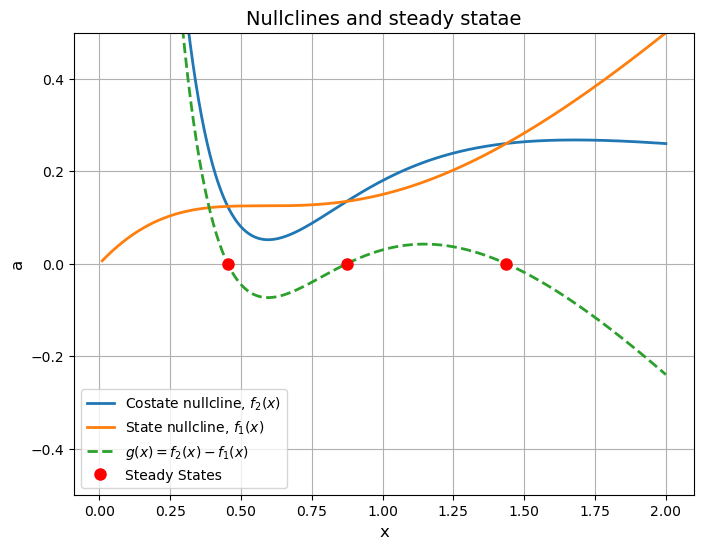

[(0.45301029168138474, 0.12418187695540228), (0.8734185245691833, 0.13498208766323055), (1.4369614660477472, 0.26030431622597555)]


In [3]:
def nullcline_a(x,p,b,c):
     return (p + b - (2*x)/((x**2 + 1)**2)) / (2 * c * x)

def nullcline_x(b,x):
    return b * x - ((x**2) / ((x**2 + 1)))

b = 0.65
p = 0.03
c = 0.5
x = np.linspace(0.01,2,1000)

f2 = nullcline_a(x, p, b, c)
f1 = nullcline_x(b, x)
g_x = f2 - f1

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, f2, label='Costate nullcline, $f_2(x)$', lw=2)
ax.plot(x, f1, label='State nullcline, $f_1(x)$', lw=2)

# Plot the difference g(x)
ax.plot(x, g_x, label='$g(x)=f_2(x)-f_1(x)$', lw=2, ls='--')

# Find and mark zeros of g(x) (steady states)
roots = []
for i in range(len(x)-1):
    if g_x[i] * g_x[i+1] < 0:
        root = fsolve(lambda xi: nullcline_a(xi, p, b, c) - nullcline_x(b, xi), (x[i] + x[i+1]) / 2)
        roots.append(root[0])
roots = np.array(roots)
if roots.size > 0:
    ax.plot(roots, np.zeros_like(roots), 'ro', markersize=8, label='Steady States')

steady_states = []
for i in range(len(roots)):
    print(f"Steady state {i+1}: x = {roots[i]:.2f}, a = {nullcline_a(roots[i], p, b, c):.2f}")
    steady_states.append((roots[i], nullcline_a(roots[i], p, b, c)))

# Customize the plot
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('a', fontsize=12)
ax.set_title('Nullclines and steady statae', fontsize=14)
ax.grid(True)
ax.legend(fontsize=10)
ax.set_ylim(-0.5, 0.5)

plt.show()

print(steady_states)

In [4]:
def jacobian_interior(x, b, lam, p, c):
    J = np.zeros((2,2))
    J[0,0] = -b + (2*x)/((x**2 + 1)**2)
    J[0,1] = 1/(lam**2)
    J[1,0] = 2*c - 2*lam * ( (1 - 3*(x**2)) / ((x**2+1)**3) )
    J[1,1] = p + b  - (2*x)/((x**2 + 1)**2)
    return J

def jacobian_boundary(x, b,lam, p, c):
    J = np.zeros((2,2))
    J[0,0] = -b + (2*x)/((x**2 + 1)**2)
    J[0,1] = 0
    J[1,0] = 2*c - 2*lam * ( (1 - 3*(x**2)) / ((x**2+1)**3) )
    J[1,1] = p + b  - (2*x)/((x**2 + 1)**2)
    return J

eigenvalues = []
for idx, (x,a) in enumerate(steady_states):
    lam = -1/a
    if idx == 1:
        J = jacobian_interior(x, b, lam, p, c)
    else:
        J = jacobian_interior(x, b, lam, p, c)
    eigs = eigvals(J)
    if eigs[0] > 0 and eigs[1] < 0:
        print(f"Eigenvalues of steady state at x = {x:.2f}, a = {a:.2f}: {eigs} \n Steady state (x={x:.2f} , a = {a:.2f}) is a saddle point")
    else:
            print(f"Eigenvalues of steady state at x = {x:.2f}, a = {a:.2f}: {eigs}")
    eigenvalues.append(eigs)

    


Eigenvalues of steady state at x = 0.45, a = 0.12: [-0.25267566+0.j  0.28267566+0.j]
Eigenvalues of steady state at x = 0.87, a = 0.13: [0.015+0.18625483j 0.015-0.18625483j]
Eigenvalues of steady state at x = 1.44, a = 0.26: [-0.3055272+0.j  0.3355272+0.j]
